In [2]:
!mkdir -p model
# !pip install scikit-plot > /dev/null

In [1]:
import numpy as np
import os,time
import cv2
import keras
from keras import backend as K
from keras import layers
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import pandas as pd
from tensorflow.keras.utils import plot_model

Using TensorFlow backend.
/homes/nv304/virtpy3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/homes/nv304/virtpy3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/homes/nv304/virtpy3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/homes/nv304/virtpy3/lib/python3.6/site-packages/tensorflow/py

In [2]:
batch_size = 128
buffer_size = 10000
steps_per_epoch = int(np.ceil(60000 / float(batch_size)))  # = 469
epochs = 10
num_classes = 10

In [3]:
class ProcessData:
    def __init__(self, train, test, val, num_classes=10, original_shape=(28,28), final_shape=(32,32)):
        self.num_classes = num_classes
        self.original_shape = original_shape
        self.final_shape = final_shape
        (x_train,y_train) = train
        (x_test,y_test) = test
        (x_val,y_val) = val
        ((self.x_train, self.y_train), (self.x_test, self.y_test), (self.x_val, self.y_val)) = map(self.reshape_dims, [train, test, val])

    def reshape_dims(self, d):
        (x,y) = d
        x = x.astype('float32')
        x = x.reshape(x.shape[0], self.original_shape[0], self.original_shape[1], 1)
        pad_0 = int((self.final_shape[0]-self.original_shape[0])/2)
        pad_1 = int((self.final_shape[1]-self.original_shape[1])/2)
        x = np.pad(x, ((0,0),(pad_0,pad_1),(pad_0,pad_1),(0,0)), 'constant')
        x = np.stack((x,)*3, axis=-1)
        x = x[:,:,:,0,:]
        y = keras.utils.to_categorical(y, self.num_classes)
        return x, y

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.33, random_state=42)
print(x_train.shape,y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape,y_test.shape)
data = ProcessData((x_train, y_train), (x_test, y_test), (x_val, y_val), num_classes=10, original_shape=(28,28), final_shape=(224,224))
print(data.x_train.shape,data.y_train.shape)
print(data.x_val.shape, data.y_val.shape)
print(data.x_test.shape,data.y_test.shape)

(40200, 28, 28) (40200,)
(19800, 28, 28) (19800,)
(10000, 28, 28) (10000,)
(40200, 224, 224, 3) (40200, 10)
(19800, 224, 224, 3) (19800, 10)
(10000, 224, 224, 3) (10000, 10)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8


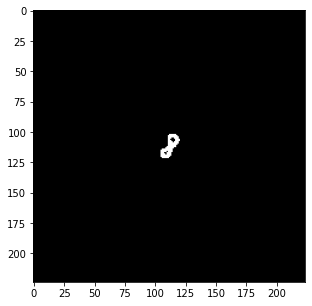

In [6]:
import random
%matplotlib inline

index = random.randint(0, len(data.x_train))
image = data.x_train[index].squeeze()

plt.figure(figsize=(5,5))
plt.imshow(image, cmap="gray")
print(y_train[index])

In [7]:
print("Train shape",data.x_train.shape, y_train.shape)
print("Val shape",data.x_val.shape, y_val.shape)
print("Test shape",data.x_test.shape, y_test.shape)

Train shape (40200, 224, 224, 3) (40200,)
Val shape (19800, 224, 224, 3) (19800,)
Test shape (10000, 224, 224, 3) (10000,)


In [24]:
def cnn_layers(inputs,classes):
    # Block 1
    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv1')(inputs)
    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = layers.Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv1')(x)
    x = layers.Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv1')(x)
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv2')(x)
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv3')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv1')(x)
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv2')(x)
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv3')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv1')(x)
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv2')(x)
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv3')(x)
    if x.shape[1] > 0:
        x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    
    x = layers.Flatten(name='flatten')(x)
    x = layers.Dense(4096, activation='relu', name='fc1')(x)
#     x = layers.Dropout(0.2)(x)
    x = layers.Dense(4096, activation='relu', name='fc2')(x)
#     x = layers.Dropout(0.2)(x)
    x = layers.Dense(1000, activation='relu', name='fc3')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(classes, activation='softmax', name='predictions')(x)
#     predictions = layers.Activation('softmax')(x)

    return x

In [25]:
input_shape = data.x_train.shape[1:]

inputs = layers.Input(shape=input_shape)
model_output = cnn_layers(inputs,num_classes)
model = keras.models.Model(inputs=inputs, outputs=model_output)

model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])
                 
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [26]:
plot_model(model, to_file='model/vgg.png')

In [ ]:
start = time.time()
history = model.fit(data.x_train, data.y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(data.x_val, data.y_val))
end = time.time()
total_exec_time = end - start

Train on 40200 samples, validate on 19800 samples
Epoch 1/10
40200/40200 [==============================] - 276s 7ms/step - loss: 14.4711 - accuracy: 0.0998 - val_loss: 14.5323 - val_accuracy: 0.0984
Epoch 2/10
40200/40200 [==============================] - 276s 7ms/step - loss: 14.5163 - accuracy: 0.0994 - val_loss: 14.5323 - val_accuracy: 0.0984
Epoch 3/10
 3584/40200 [=>............................] - ETA: 3:30 - loss: 14.5216 - accuracy: 0.0991

In [12]:
# Save the model weights.
weight_path = 'model/vgg16_wt.h5'
model.save_weights(weight_path)

In [13]:
score = model.evaluate(data.x_test, data.y_test, verbose=1,batch_size=batch_size)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 1s 75us/step
Test loss: 0.08309286470102961
Test accuracy: 0.9872999787330627


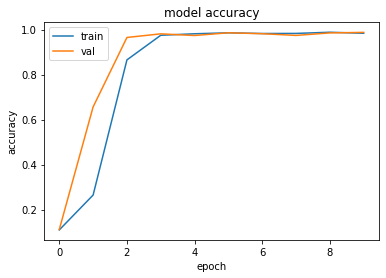

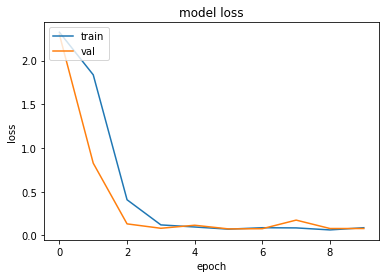

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [15]:
predictions = model.predict(data.x_test, verbose=0)

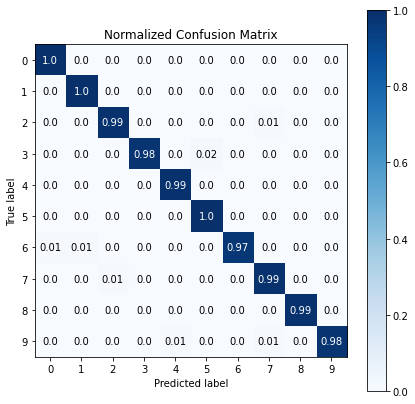

In [16]:
# from sklearn.metrics import classification_report, confusion_matrix
# confusion_matrix(np.argmax(data.y_test,axis=1),np.argmax(predictions,axis=1))
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(np.argmax(data.y_test,axis=1),np.argmax(predictions,axis=1), normalize=True,figsize = (7,7))

### Error Analysis

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

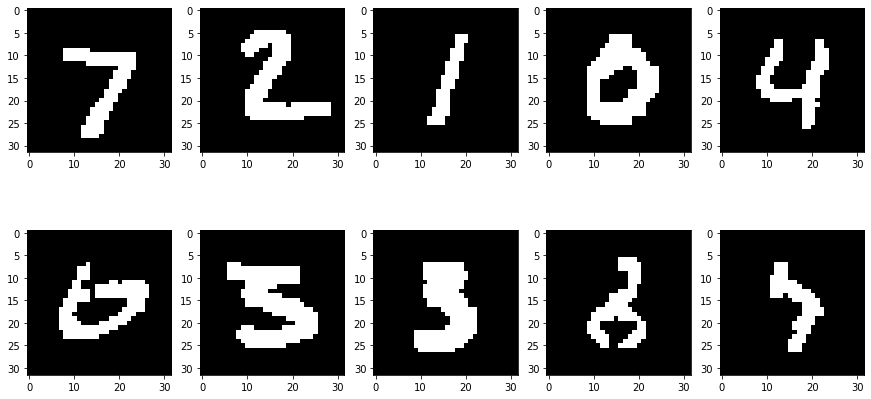

True:          [7 2 1 0 4]
classified as: [7 2 1 0 4]
True:          [6 3 3 8 7]
classified as: [0 5 5 2 8]


In [17]:
def test_accuracy():
    err = []
    tru = []
    for i in range(predictions.shape[0]):
        if (np.argmax(predictions[i]) == y_test[i]):
            tru.append(i)
        else:
            err.append(i)
    return tru, err

p = test_accuracy()

fig1 = plt.figure(figsize = (15,15))
for i in range(5):
    ax1 = fig1.add_subplot(1,5,i+1) 
    ax1.imshow(data.x_test[p[0][i]], interpolation='none', cmap=plt.cm.gray)
    ax2 = fig1.add_subplot(2,5,i+6) 
    ax2.imshow(data.x_test[p[1][i+6]], interpolation='none', cmap=plt.cm.gray)
plt.show()

print("True:          {}".format(np.argmax(data.y_test[p[0][0:5]], axis =1)))
print("classified as: {}".format(np.argmax(predictions[p[0][0:5]], axis=1)))
print("Error Cases")
print("True:          {}".format(np.argmax(data.y_test[p[1][6:11]], axis =1)))
print("classified as: {}".format(np.argmax(predictions[p[1][6:11]], axis=1)))

In [18]:
hist = {}
hist['model_name'] = 'VGG16'
hist['input_dims'] = data.x_train.shape[1:]
hist = dict(hist, **history.history)
hist['test_loss'] = score[0]
hist['test_accuracy'] = score[1]
np.save('model.txt',hist)

result = pd.DataFrame()
result = result.append(hist, ignore_index=True)
result

,accuracy,input_dims,loss,model_name,test_accuracy,test_loss,val_accuracy,val_loss
0,"[0.10997512, 0.26487562, 0.8654229, 0.97477615...","(32, 32, 3)","[2.325062925044577, 1.8380589820377862, 0.4081...",VGG16,0.9873,0.083093,"[0.11181817948818207, 0.6564141511917114, 0.96...","[2.2990328035450944, 0.8268948816530632, 0.132..."


In [20]:
K.clear_session()